Для начала я собираю данные о государственных контрактах с API new.clearspending.ru. Код делает запросы по годам и диапазонам сумм контрактов и объединяет их в один датафрейм df_all. Если возникает ошибка или превышен лимит запросов, код повторяет попытку.
Результат — таблица, содержащая сведения о контрактах за заданные годы и диапазоны сумм.

In [17]:
import pandas as pd
import json
import requests
from flatten_json import flatten
import time

list_of_all_dfs = []
key = "wOHqT7E8Gnc9aXsivxNWB2cEmlOJ7A8I"

# добавляю годы для анализа и диапазоны сумм контрактов в рублях
years = ["2020", "2021", "2022", "2023", "2024"]
amount_ranges = [(100000, 1000000), (1000000, 10000000), (10000000, 50000000), (50000000, 100000000)]

# циклом прохожусь по каждому году и диапазону сумм
for year in years:
    for amount_min, amount_max in amount_ranges:
        for page in range(1, 6):
            url = (
                f"https://newapi.clearspending.ru/csinternalapi/v1/filtered-contracts/"
                f"?apikey={key}&format=json&sign_date_gte={year}-01-01&sign_date_lte={year}-12-31"
                f"&amount_rur_gte={amount_min}&amount_rur_lte={amount_max}&page={page}"
            )

            for attempt in range(5):
                response = requests.get(url)
                print(f"Год {year}, сумма {amount_min}-{amount_max}, страница {page}, статус: {response.status_code}")

                if response.status_code == 200:
                    break
                elif response.status_code == 429:
                    print("Превышен лимит запросов. Ждем 5 секунд перед повтором...")
                    time.sleep(5)
                else:
                    print(f"Ошибка при запросе. Пропускаем страницу {page}.")
                    break

            data = response.json() if response.status_code == 200 else {}

            df = pd.DataFrame()
            for record in data.get("data", []):
                ser = pd.Series(flatten(record))
                df = pd.concat([df, ser.to_frame().T], ignore_index=True)

            list_of_all_dfs.append(df)

df_all = pd.concat(list_of_all_dfs, ignore_index=True)

print(f"Всего строк собрано: {len(df_all)}")

Год 2020, сумма 100000-1000000, страница 1, статус: 200
Год 2020, сумма 100000-1000000, страница 2, статус: 200
Год 2020, сумма 100000-1000000, страница 3, статус: 200
Год 2020, сумма 100000-1000000, страница 4, статус: 200
Год 2020, сумма 100000-1000000, страница 5, статус: 200
Год 2020, сумма 1000000-10000000, страница 1, статус: 200
Год 2020, сумма 1000000-10000000, страница 2, статус: 200
Год 2020, сумма 1000000-10000000, страница 3, статус: 200
Год 2020, сумма 1000000-10000000, страница 4, статус: 200
Год 2020, сумма 1000000-10000000, страница 5, статус: 200
Год 2020, сумма 10000000-50000000, страница 1, статус: 200
Год 2020, сумма 10000000-50000000, страница 2, статус: 200
Год 2020, сумма 10000000-50000000, страница 3, статус: 200
Год 2020, сумма 10000000-50000000, страница 4, статус: 200
Год 2020, сумма 10000000-50000000, страница 5, статус: 200
Год 2020, сумма 50000000-100000000, страница 1, статус: 200
Год 2020, сумма 50000000-100000000, страница 2, статус: 200
Год 2020, сумма

In [21]:
df_all

,amount,amount_rur,currency,current_stage,customer_inn,customer_kpp,customer_name,exec_start_date,exec_start_date_timestamp,fed_district_code,...,product_names_1045,product_names_1046,product_names_1047,product_names_1048,product_names_1049,product_names_1050,product_names_1051,product_names_1052,product_names_1053,product_names_1054
0,486720.0,486720.0,RUB,None,7102000154,710701001,"АКЦИОНЕРНОЕ ОБЩЕСТВО ""ТУЛАГОРГАЗ""",2020-03-04,None,CFO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,466918.0,466918.0,RUB,None,7107033763,710701001,"ПУБЛИЧНОЕ АКЦИОНЕРНОЕ ОБЩЕСТВО ""ОКТАВА""",2020-01-01,None,CFO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,229000.0,229000.0,RUB,None,7107109250,710701001,"АКЦИОНЕРНОЕ ОБЩЕСТВО ""СПЕЦАВТОХОЗЯЙСТВО""",2020-01-13,None,CFO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,236588.76,236588.76,RUB,None,7118506482,711801001,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ЩЕКИ...",2020-01-01,None,CFO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,511014.0,511014.0,RUB,None,7118506482,711801001,"ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ЩЕКИ...",2020-03-11,None,CFO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1955,80000000.0,80000000.0,RUB,None,2308077190,230801001,МИНИСТЕРСТВО ТРАНСПОРТА И ДОРОЖНОГО ХОЗЯЙСТВА ...,2025-01-01,None,YUFO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1956,70000000.0,70000000.0,RUB,None,2308077190,230801001,МИНИСТЕРСТВО ТРАНСПОРТА И ДОРОЖНОГО ХОЗЯЙСТВА ...,2025-01-01,None,YUFO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1957,50000000.0,50000000.0,RUB,None,3329010657,332901001,ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ВЛАДИМИРС...,2025-01-01,None,CFO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1958,60000000.0,60000000.0,RUB,None,5837061569,583701001,ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ УЧРЕЖДЕНИЕ ПЕНЗЕНСКО...,2025-01-01,None,PFO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Exploratory data analysis 

1. Объемы контрактов

In [28]:
print("Количество контрактов:", df_all.shape[0])

Количество контрактов: 1960


In [29]:
print("Средняя сумма контракта (руб):", df_all['amount_rur'].mean())
print("Медианная сумма контракта (руб):", df_all['amount_rur'].median())

Средняя сумма контракта (руб): 22686436.704846922
Медианная сумма контракта (руб): 10000000.0


In [31]:
print(df_all['currency'].value_counts()) #распределение по валютам

currency
RUB    1932
EUR      17
USD       8
CNY       2
GBP       1
Name: count, dtype: int64


2. Географическое распределение

In [33]:
print(df_all['fed_district_code'].value_counts()) #распределение по федеральным округам

fed_district_code
CFO     634
PFO     429
SFO     243
DFO     155
SZFO    144
SKFO    127
YUFO    117
URFO    111
Name: count, dtype: int64


In [38]:
print(df_all.groupby('fed_district_code')['amount_rur'].mean()) #средняя сумма по федеральным округам

fed_district_code
CFO     25341054.631356
DFO      21394332.07871
PFO     27729362.447366
SFO     13967663.625885
SKFO     6580080.105433
SZFO    26562423.471944
URFO    25559029.922613
YUFO    19618082.113248
Name: amount_rur, dtype: object


3. Заказчики

In [40]:
print(df_all['customer_name'].value_counts().head(10)) #топ 10

customer_name
АКЦИОНЕРНОЕ ОБЩЕСТВО "ДЕЛОВАЯ СРЕДА"                                                                                   123
ПУБЛИЧНОЕ АКЦИОНЕРНОЕ ОБЩЕСТВО "СБЕРБАНК РОССИИ"                                                                        96
МУНИЦИПАЛЬНОЕ УНИТАРНОЕ ПРЕДПРИЯТИЕ ГОРОДА ГРОЗНОГО "СПЕЦИАЛИЗИРОВАННОЕ УПРАВЛЕНИЕ ДОРОЖНО-МОСТОВОГО СТРОИТЕЛЬСТВА"     79
АКЦИОНЕРНОЕ ОБЩЕСТВО "ПОЧТА РОССИИ"                                                                                     46
АЛТАЙСКОЕ КРАЕВОЕ ГОСУДАРСТВЕННОЕ УНИТАРНОЕ ПРЕДПРИЯТИЕ "АПТЕКИ АЛТАЯ"                                                  32
АКЦИОНЕРНОЕ ОБЩЕСТВО "ЮНИС"                                                                                             26
ПУБЛИЧНОЕ АКЦИОНЕРНОЕ ОБЩЕСТВО "ГАЗПРОМ"                                                                                18
АКЦИОНЕРНОЕ ОБЩЕСТВО "ТРАНСНЕФТЬ - СИБИРЬ"                                                                              18
АК

4. Распределение количества контрактов по годам

In [44]:
df_all['exec_start_date'] = pd.to_datetime(df_all['exec_start_date'], errors='coerce')
print(df_all['exec_start_date'].dt.year.value_counts())

exec_start_date
2021.0    393
2022.0    387
2020.0    383
2024.0    326
2025.0    264
2023.0    173
2019.0      8
2026.0      1
Name: count, dtype: int64


5. Средняя сумма контракта по валютам:

In [45]:
print(df_all.groupby('currency')['amount_rur'].mean())

currency
CNY         64517148.1
EUR    39694922.526471
GBP         48810768.0
RUB    22307714.527759
USD        64281590.84
Name: amount_rur, dtype: object


# Графики

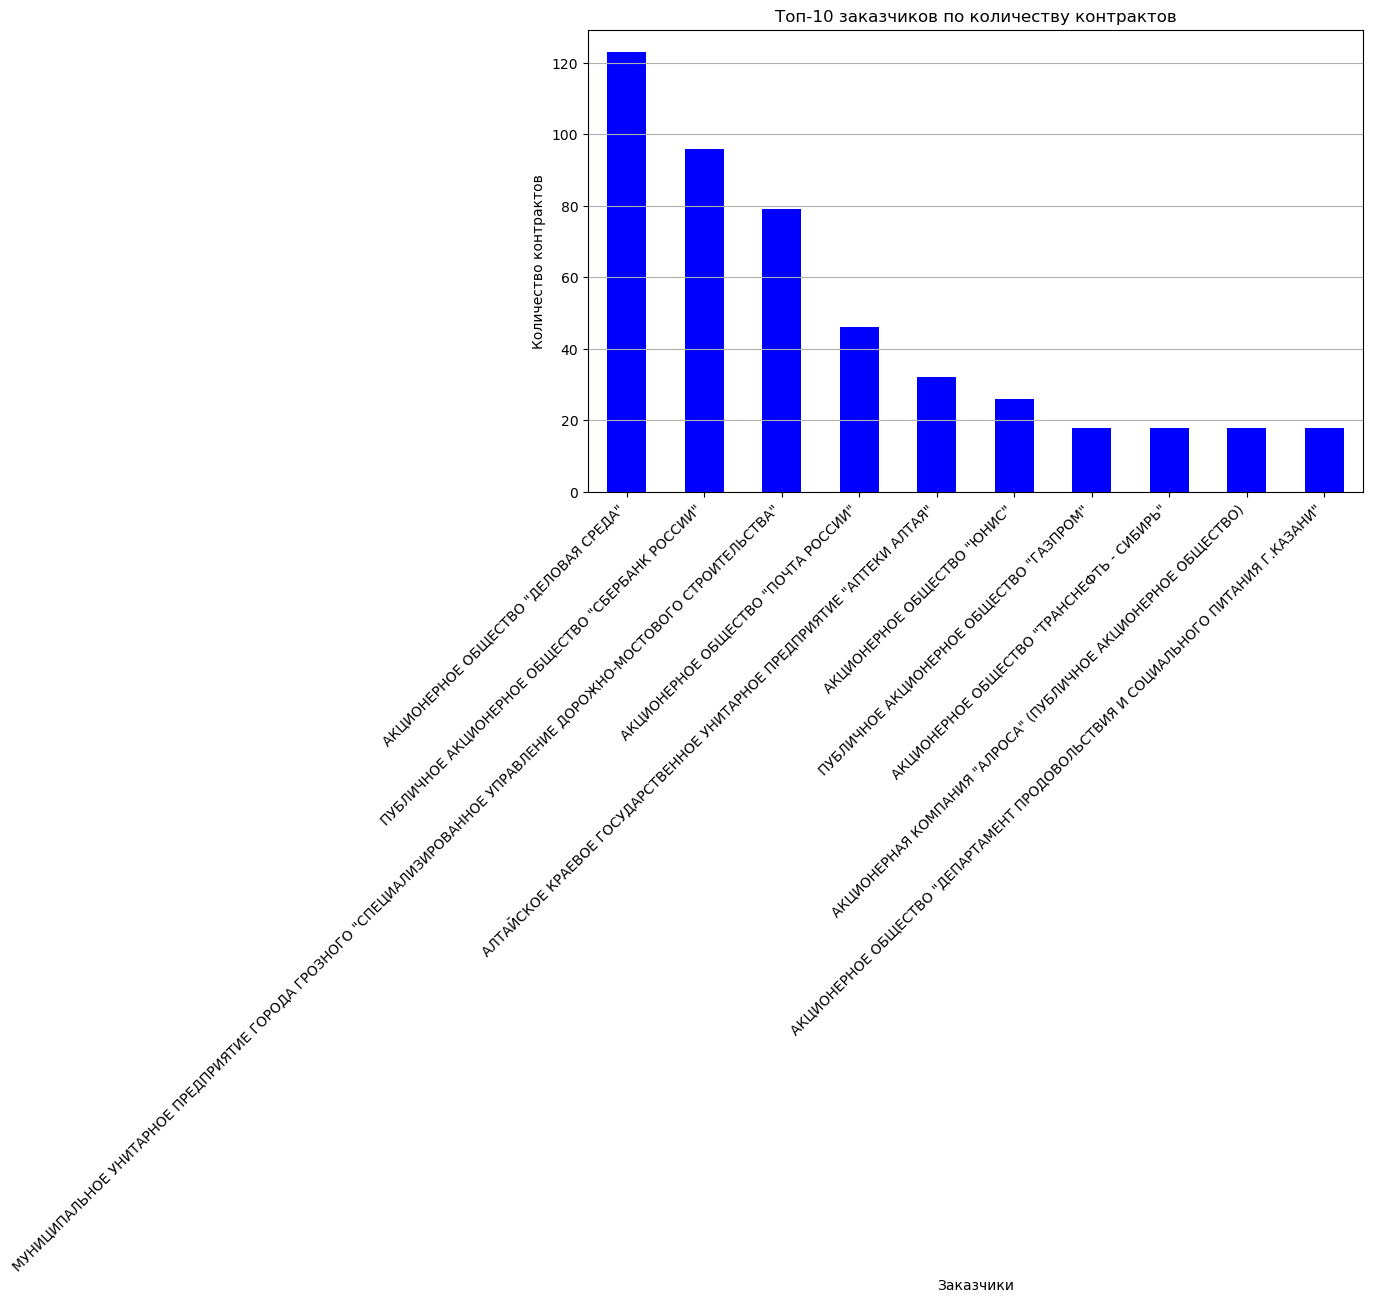

In [47]:
import matplotlib.pyplot as plt

# 1. Бар-чарт: Топ-10 заказчиков по количеству контрактов
top_customers = df_all['customer_name'].value_counts().head(10)
plt.figure(figsize=(10, 6))
top_customers.plot(kind='bar', color='blue')
plt.title('Топ-10 заказчиков по количеству контрактов')
plt.xlabel('Заказчики')
plt.ylabel('Количество контрактов')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()

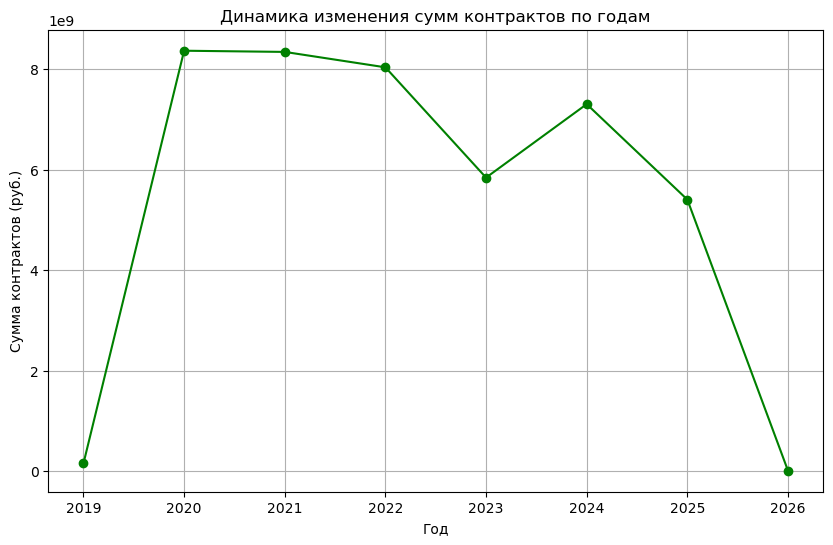

In [65]:
# 2. Линейный график: Динамика изменения сумм контрактов по годам
df_all['exec_start_date'] = pd.to_datetime(df_all['exec_start_date'], errors='coerce')
annual_amount = df_all.groupby(df_all['exec_start_date'].dt.year)['amount_rur'].sum()

plt.figure(figsize=(10, 6))
annual_amount.plot(kind='line', marker='o', color='green')
plt.title('Динамика изменения сумм контрактов по годам')
plt.xlabel('Год')
plt.ylabel('Сумма контрактов (руб.)')
plt.grid(True)
plt.show()

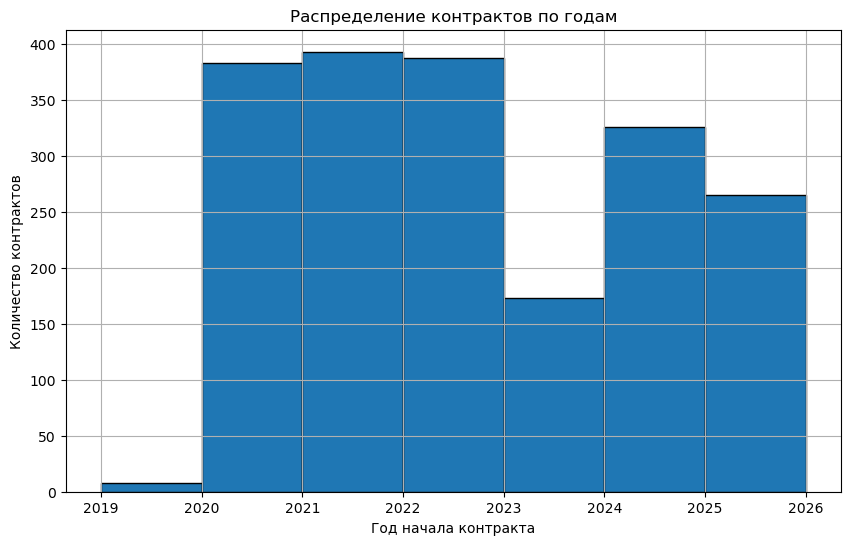

In [73]:
# 3. Гистограмма: Распределение по годам

df_all['exec_start_date'] = pd.to_datetime(df_all['exec_start_date'], errors='coerce')
df_all['exec_start_year'] = df_all['exec_start_date'].dt.year
df_all['exec_start_year'] = df_all['exec_start_year'].astype('int64')
df_all = df_all.dropna(subset=['exec_start_year'])

plt.figure(figsize=(10, 6))
plt.hist(df_all['exec_start_year'], bins=range(df_all['exec_start_year'].min(), df_all['exec_start_year'].max() + 1), edgecolor='black')
plt.xlabel('Год начала контракта')
plt.ylabel('Количество контрактов')
plt.title('Распределение контрактов по годам')
plt.grid(True)
plt.show()